Number of fraudulent transactions: 7506
Number of non-fraudulent transactions: 1289169


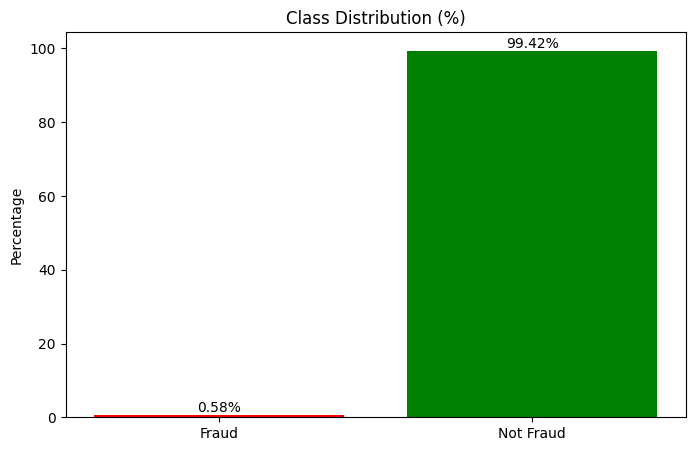

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

path = "../data/fraudTrain.csv"
df = pd.read_csv(path, index_col=0)

is_fraud = 0
is_not_fraud = 0

for col in df['is_fraud']:
    if col == 1:
        is_fraud += 1
    else:
        is_not_fraud += 1


print(f"Number of fraudulent transactions: {is_fraud}")
print(f"Number of non-fraudulent transactions: {is_not_fraud}")

labels = ['Fraud', 'Not Fraud']
values = [is_fraud, is_not_fraud]
total = is_fraud + is_not_fraud

fraud_percentage = (is_fraud / total) * 100
not_fraud_percentage = (is_not_fraud / total) * 100

labels = ['Fraud', 'Not Fraud']
values = [fraud_percentage, not_fraud_percentage]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, values, color=['red', 'green'])

plt.title('Class Distribution (%)')
plt.ylabel('Percentage')

for bar, value in zip(bars, values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f'{value:.2f}%',
        ha='center',
        va='bottom'
    )

plt.show()



Observemos que la cantidad de trasacciones fraudulentas son muy insignificante al lado de las trasancciones normales. Por lo tanto el dataset esta altamente desbalanceado. Esto quiere decir que no podemos realizar un modelo simple que indique si tenemos una trasacciones fraudulenta o no, ya que siempre va predecir que no lo es, lo cual nos llevaria a tener un modelo inutil, sin practicamente informacion de la cual aprender.


Aca entra SMOTE (Synthetic Minority Over-sampling Technique):

¿Qué hace? En lugar de simplemente duplicar las filas de fraude existentes, SMOTE mira los puntos de fraude en el espacio multidimensional y crea nuevos puntos sintéticos en el medio de ellos.

Resultado: Inventa datos de fraude "verosímiles" para que tu modelo de Sklearn (como un Random Forest) tenga suficientes ejemplos para aprender los patrones del robo.